(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Clustering the data from the Mayor's 24-hour hotline in Boston

## Introduction 

In this assignment, we will do a clustering analysis on the 311 calls that we used in the previous homework. We will focus on choosing a value for k, clustering based on multiple features and detecting outliers.

---------------------------

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Translate different non-numeric data features into numeric matrix using DictVectorizer.
import sklearn.feature_extraction as ft_extra

In [2]:
# boston = pd.read_csv('../Homework-2/cases_2015.csv')
boston = pd.read_csv('cases_2015.csv')
boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46698 entries, 0 to 46697
Data columns (total 33 columns):
CASE_ENQUIRY_ID                   46698 non-null int64
OPEN_DT                           46698 non-null object
TARGET_DT                         41129 non-null object
CLOSED_DT                         35141 non-null object
OnTime_Status                     46694 non-null object
CASE_STATUS                       46698 non-null object
CLOSURE_REASON                    35175 non-null object
CASE_TITLE                        46679 non-null object
SUBJECT                           46698 non-null object
REASON                            46698 non-null object
TYPE                              46698 non-null object
QUEUE                             46698 non-null object
Department                        46698 non-null object
SubmittedPhoto                    7245 non-null object
ClosedPhoto                       1217 non-null object
Location                          44442 non-null objec

## Step 1. Simple clustering

The first thing that we will try is to cluster the geolocation data of the calls. The geolocation of a record consists of a pair `(latitude, longitude)`, which represents the position of the record on the map. Since the dataset that we have spans only a small geographic location, i.e. Boston, we will use the Euclidean distance when measuring how close two points are. Techinically, we should pick a [projection](https://github.com/mbostock/d3/wiki/Geo-Projections) in order to transform the data into 2d, and measure  the Euclidean distance in the projected space.

Since we are dealing with numeric data, we might consider centering and normalizing them. In order to do that, check the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from `scikit-learn`.

For exampe, the result of a clustering with 10 clusters is the following:


![A clustering of the locations of the calls for k=10](clusters10.png)

Filter the dataset to get the latitude and longitude, transform it as required and run the k-means clustering algorithm. Argue about the number of clusters you used. **(pts 50)**

In [31]:
# Gathering the columns of latitude & longitude
geo = np.array(boston[['LATITUDE','LONGITUDE']])
# Normalize the training dataset
geo_norm = preprocessing.StandardScaler().fit_transform(geo)

# Gathering the columns of latitude & longitude separately for plot later
la = preprocessing.StandardScaler().fit_transform(np.array(boston['LATITUDE']))
lo = preprocessing.StandardScaler().fit_transform(np.array(boston['LONGITUDE']))

In [67]:
# Finding the best K
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

In [ ]:
evaluate_clusters(geo_norm,30)

In [5]:
# Take an example of K=10
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit_predict(geo_norm)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

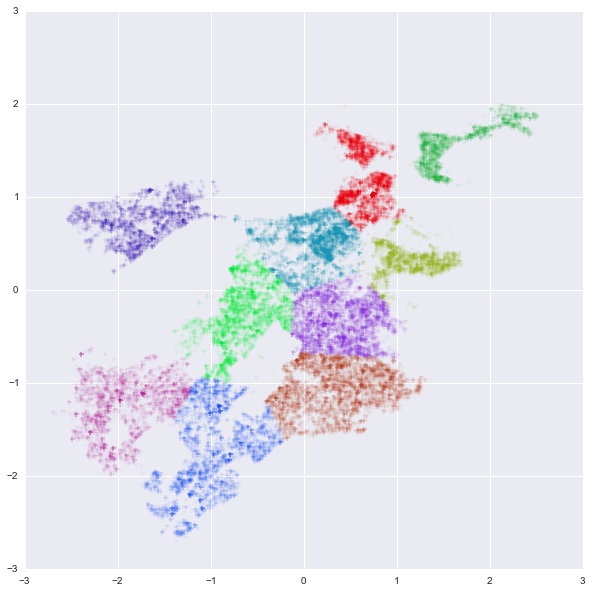

In [9]:
# Plot the scatter graph
fig, ax = plt.subplots(1,1,figsize=(10,10))
# I have 10 clusters, so I need 10 colors. Each colormap can produce 10 colors
# so I am mixing two colormaps that I tested that work well together
cmap = sns.color_palette("bright", n_colors=4)
cmap.extend(sns.hls_palette(n_colors=6, h=0.7, l=0.4, s=0.8))

# for each label, isolate the points of that label and plot them with the same color
for i, label in enumerate(set(labels)):
    point_indices = np.where(labels == label)[0]
    point_indices = point_indices.tolist()
    plt.scatter(lo[point_indices], la[point_indices], s=25, alpha=0.2, c=cmap[i], marker='+')

In [ ]:
# def sc_evaluate_clusters(X,max_clusters):
#     s = np.zeros(max_clusters+1)
#     s[0] = 0;
#     s[1] = 0;
#     for k in range(2,max_clusters+1):
#         kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
#         kmeans.fit_predict(X)
#         s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
#     plt.plot(range(2,len(s)),s[2:])
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Adjusted Rand Index')
 
# sc_evaluate_clusters(geo_norm,20)

-----

## Step 2. Using multiple features

The next step in our analysis is to use more features than just the geolocation of a record (whose clustering only gives us information about the neighborhoods, which should not be a huge revelation!) Filter the dataset to get more features, transform them as required and compute another clustering. You should argue about the quality of your clustering and use domain knowledge (i.e. the fact that you are locals) to explore the clusters you produced and present them to the reader. **(pts 30)**

In [62]:
# Adding more features
# One way to filter the noise data like NaN
features_1 = boston[['LATITUDE','LONGITUDE','fire_district','city_council_district','neighborhood_services_district','precinct','LOCATION_ZIPCODE','Property_ID']]
features_1 = features_1[features_1['LOCATION_ZIPCODE'].notnull()]
features_1 = features_1[features_1['fire_district'].notnull()]
features_1 = features_1[features_1['precinct'].notnull()]

features_1 = np.array(features_1)
# Standardize the training dataset
Xtrain = preprocessing.StandardScaler().fit_transform(features_1)

In [60]:
# Another way to process data
# but with missing values like NaN
features_2 = boston[['LATITUDE','LONGITUDE','fire_district','city_council_district','neighborhood_services_district','precinct','LOCATION_ZIPCODE','Property_ID']]
proc = preprocessing.Imputer(missing_values='NaN')
features_2 = proc.fit_transform(features_2)

# Standardize
features_2 = preprocessing.StandardScaler().fit_transform(features_2)

In [61]:
# Adding features that are non-numeric values, such as 'CASE_TITLE'
# str_feature = boston['CASE_TITLE']
# str_feature = [boston['CASE_TITLE'].notnull()]

enc = preprocessing.LabelEncoder()
uniq = pd.Series(boston['CASE_TITLE'].values.ravel()).unique()
enc.fit(uniq)
list(enc.classes_)
features_3 = enc.transform(boston['CASE_TITLE'])

In [ ]:
# Another way of converting non-numeric data
# vectorizer = ft_extra.DictVectorizer()
# vectorizer.fit_transform(str_feature).toarray()
# new_Xtrain = ft_extra.text.TfidfVectorizer(str_feature)

In [65]:
# Merge Features 2 & 3
f2 = features_2.tolist()
f3 = features_3.tolist()

l = len(features_3)

for i in range(l):
    f2[i].append(f3[i])

features = np.array(f2)

array([[  9.57006334e-01,   5.61374685e-01,  -1.35757097e+00, ...,
         -1.36923584e+00,  -9.35936072e-01,   4.63000000e+02],
       [  6.68763294e-01,  -2.73098720e-01,  -1.03653325e+00, ...,
          6.32477600e+00,   7.03770529e-01,   4.80000000e+02],
       [  6.68763294e-01,  -2.73098720e-01,  -1.03653325e+00, ...,
          6.32477600e+00,   7.03770529e-01,   4.80000000e+02],
       ..., 
       [ -1.43252847e+00,  -2.39268717e-01,   2.47617648e-01, ...,
         -7.49160921e-02,   1.06814230e+00,   5.81000000e+02],
       [  1.01465494e+00,   7.33343866e-01,  -7.07144171e-14, ...,
          3.45632233e-11,   2.74206608e-14,   5.28000000e+02],
       [ -1.42099874e+00,  -2.39268717e-01,   2.47617648e-01, ...,
         -7.49160921e-02,  -8.77566600e-01,   3.61000000e+02]])

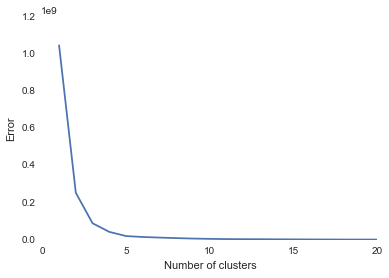

In [68]:
# evaluate_clusters(Xtrain,20)

evaluate_clusters(features,20)

# Based on this graph, we decide clusters=7 is a good choice

In [70]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit_predict(features)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

In [71]:
print "The total error of the clustering is: ", error
print '\nCluster labels'
print labels
print '\n Cluster Centroids'
print centroids

The total error of the clustering is:  11990134.087

Cluster labels
[3 5 5 ..., 6 5 4]

 Cluster Centroids
[[  9.33817847e-02   6.30618983e-02  -1.30882172e-01  -1.99340865e-02
   -9.83569552e-03  -9.17207105e-02   6.11647083e-02   6.99707324e-02
    7.24327234e+02]
 [ -9.69705628e-02  -2.14734819e-02   1.18521224e-02  -7.21100735e-03
    1.71249568e-03   6.62264691e-03  -3.00797903e-02  -4.97109816e-02
    5.59506628e+02]
 [  2.67829631e-01   1.94461549e-01  -1.49589486e-01  -5.76256762e-02
   -6.98778261e-02  -1.34089464e-01   1.42830579e-02   1.16967913e-01
    5.46223103e+01]
 [  4.13060109e-02  -6.29548854e-02   1.04998055e-01   8.39197579e-02
    8.07357389e-02   1.30345576e-01   6.37830402e-02   4.37317740e-02
    4.35294853e+02]
 [ -2.94434302e-02   8.76426245e-02  -3.90331781e-02  -3.89849886e-02
   -1.38318142e-02  -1.20765865e-02  -7.10311550e-02   2.82583939e-01
    3.27052244e+02]
 [  1.93338402e-01   5.79372257e-02   1.34882385e-02   4.10714970e-02
    4.11986341e-02  -1.

-----

## Step 3. Detecting outliers

Now that we have a clustering of the records in the dataset, we can detect the outlying ones. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(pts 20)** 

In [73]:
# Calculate the euclidean distance between 2 given points
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

n = len(centroids)

fartherest = range(n)
for k in fartherest:
    center = centroids[k]
    max_dist = 0
    for i in range(l):
        if labels[i] == k:
            new_dist = dist(features[i],center)
            if new_dist > max_dist:
                max_dist = new_dist
                fartherest[k] = features[i]
            
#     distance = metrics.euclidean_distances(center,Xtrain)
#     fartherest.append(np.argmax(distance))

In [74]:
fartherest

[array([  6.48586282e-01,  -2.14220638e+00,   1.21073082e+00,
          1.77719274e+00,   1.52035741e+00,   1.56313948e+00,
          3.45632233e-11,  -9.64369318e-01,   6.54000000e+02]),
 array([  7.81178080e-01,   1.72329652e-01,  -1.03653325e+00,
          1.37102610e+00,   1.27138204e+00,  -1.05160363e+00,
         -7.93982619e-01,  -6.35070829e-01,   5.33000000e+02]),
 array([  1.01465494e+00,   7.33343866e-01,  -7.07144171e-14,
         -2.66953851e-14,  -9.11074329e-14,   3.98446252e-14,
          3.45632233e-11,   2.74206608e-14,   1.90000000e+02]),
 array([ -1.21022634e-01,  -6.67782087e-01,   5.68655372e-01,
          5.58692816e-01,   5.24455950e-01,   1.09122523e+00,
          2.12710519e-01,   2.20950999e+00,   3.82000000e+02]),
 array([  4.46816154e-01,   2.85096328e-01,  -1.03653325e+00,
         -1.06597375e+00,  -7.20420873e-01,  -4.45954723e-01,
          3.45632233e-11,  -9.75114505e-01,   1.91000000e+02]),
 array([ -1.71788907e+00,  -8.67942937e-01,   1.53176855e+00

In [1]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()

IOError: [Errno 2] No such file or directory: '../../theme/custom.css'